There are two main ways geospatial data are stored
- rasters, where each 'pixel' stores data values. This corresponds to files such as geotiffs.
- vectors, where information is stored more like a table form, and each row will have a 'geometry' field which stores information that allows you to recreate a geographical feature, such as a point , a polygon etc. It might also store the coordinate reference system so you can correctly place the shapes on a map

This set of notes corresponds to handling raster data. For this, we will make use of the [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) library for manipulating the data, as well as [pyproj](https://pyproj4.github.io/pyproj/stable/) for coordinate transforms.

(You can access a running version of this notebook on colab [here](https://colab.research.google.com/drive/1ZW7633qzhV7UWxcBNYV8jo4Ok9a5oI2i))

### Setup

For this demo, I will be using a population dataset from NASA ["Gridded Population of the World, Version 4 (GPWv4): Population Count Adjusted to Match 2015 Revision of UN WPP Country Totals"](http://sedac.ciesin.columbia.edu/data/collection/gpw-v4/sets/browse)

In [6]:
!pip install rasterio pyproj --quiet

In [41]:
import rasterio
import pyproj
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### peak at data:
asc is much like a text file and we can use conventional text handling tools and a bit of pandas to parse it, but it is much less mistake prone if we use rasterio to handle it

In [8]:
!cat gpw_v4_population_count_adjusted_to_2015_unwpp_country_totals_rev11_2020_1_deg.asc | head -10

ncols         360
nrows         180
xllcorner     -180
yllcorner     -90
cellsize      1.0000000000001
NODATA_value  -9999
-9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -

In [9]:
!cat gpw_v4_population_count_adjusted_to_2015_unwpp_country_totals_rev11_2020_1_deg.prj | head -10

Projection    GEOGRAPHIC
Datum         WGS84
Spheroid      WGS84
Units         DD
Zunits        NO
Parameters    


### parsing the data

For this example, we would like to convert the raster to a tabular form we can store in a 'conventional' database/csv file. For this, we will do these tasks:
1. read the file into memory
2. filter out any pixels/cells with no data
3. convert the data into a 'long' table with the format `longitude | latitude | population | `
4. obtain the lat/lng values in [web mercator coordinates](https://epsg.io/3857)

1. Read the file: note that rasterio can also open files on certain cloud providers, such as GCS/S3 etc, just pass it the relevant filepath in `gs://`, `s3://` format

In [10]:
dataset =  rasterio.open("gpw_v4_population_count_adjusted_to_2015_unwpp_country_totals_rev11_2020_1_deg.asc") 

the dataset object holds metadata:

In [11]:
# extent of the data and crs -- note we are getting the CRS info from the .prj file also supplied
dataset.bounds, dataset.crs

(BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0),
 CRS.from_epsg(4326))

The actual values of the pixels are in the 1st 'band'. There can be more than 1 band-- for example satellite imagery can comes in > 10 bands. We can either read all the bands in at once, or one by one. (Note that the indexing starts with 1 for the bands if reading in one by one)

In [12]:

data= dataset.read()
data.shape

(1, 180, 360)

In [ ]:
# from the above, we know that there is only 1 band, so we can convert the data to a 2d array
data = data.squeeze()

2. remove all pixels with no data

In [17]:

valid_rows, valid_cols = np.nonzero(data != dataset.get_nodatavals())
valid_data_vals = data[(valid_rows, valid_cols)]

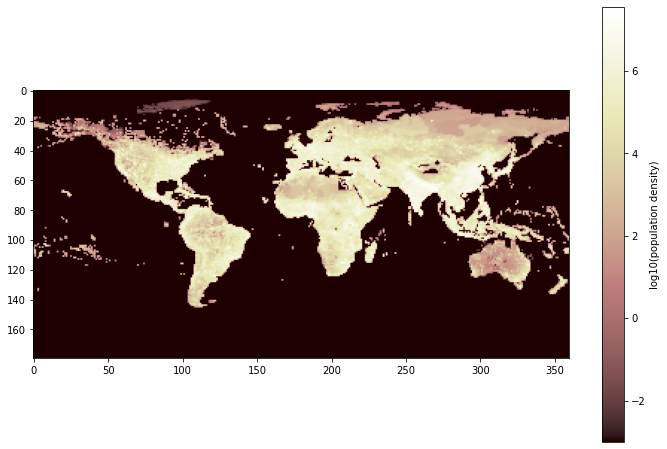

In [38]:
plt_data = np.zeros_like(data)
plt_data[(valid_rows, valid_cols)] = valid_data_vals

f, ax = plt.subplots(figsize=(12, 8))
ax1 = ax.imshow(np.log10(plt_data+0.001), cmap='pink')
f.colorbar(ax1, label=f"log10(population density)");

3. Convert pixel positions to coordinates:

In [21]:
# covert rows, cols to coordinates:
valid_lngs, valid_lats = rasterio.transform.xy(dataset.transform, valid_rows, valid_cols)
output_dataframe = pd.DataFrame(
    data = dict(
        lat=valid_lats,
        lng = valid_lngs,
        population = valid_data_vals
    )
)
output_dataframe.sample(frac=1.).head()

,lat,lng,population
6506,53.5,124.5,9.351563e+03
1035,75.5,141.5,1.780356e+02
3034,66.5,72.5,1.972377e+03
7488,48.5,-113.5,9.566622e+03
10740,32.5,116.5,4.994749e+06


Add lat lng values in web mercator:

(note that it is a good idea to  `always_xy` param to be true, this means the order of the output is always in the coordinates' equivalent to longitude, latitude. There are CRS that can end up swapping the x, y axis from the source CRS)

In [44]:
dataset.crs

CRS.from_epsg(4326)

In [45]:
transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

In [46]:
lng_3857, lat_3857 = transformer.transform(output_dataframe.lng.values.squeeze(), output_dataframe.lat.values.squeeze())

output_dataframe['lng_3857'] = lng_3857
output_dataframe['lat_3857'] = lat_3857
output_dataframe.sample(frac=1.).head()

,lat,lng,population,lng_3857,lat_3857
11941,25.5,124.5,2.870859e+01,1.385928e+07,2.937284e+06
17692,-22.5,117.5,4.557170e+03,1.308004e+07,-2.571663e+06
44,82.5,-77.5,3.311810e-02,-8.627261e+06,1.738069e+07
9618,38.5,46.5,1.455383e+06,5.176356e+06,4.650302e+06
16594,-12.5,122.5,1.345766e-03,1.363664e+07,-1.402665e+06


In [49]:
# verify and sanity check
output_dataframe.isnull().sum()

lat           0
lng           0
population    0
lng_3857      0
lat_3857      0
dtype: int64